In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from scipy import stats
import seaborn as sns
sns.set_style('whitegrid') #设置seaborn的风格
#设置中文显示
rc = {'font.sans-serif': 'SimHei', 
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)

import sklearn.linear_model as LM #建立线性预测模型
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut,LeavePOut # 数据集划分
from sklearn.model_selection import cross_val_score,cross_validate  #交叉验证
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,auc,precision_recall_curve,accuracy_score,mean_squared_error #模型评价

import os #系统管理

# 一、对三部分表的合并

In [16]:
df1 = pd.read_csv(R"C:\Users\英俊潇洒的不爱言\Desktop\并行计算论文\金融市级.csv")
df1

,年份,省,市,年末金融机构人民币各项贷款余额_万元_全市
0,2016,北京市,北京市,488531687.0
1,2017,北京市,北京市,566188715.0
2,2018,北京市,北京市,633825000.0
3,2019,北京市,北京市,704836718.0
4,2020,北京市,北京市,735759400.0
...,...,...,...,...
1735,2017,新疆维吾尔自治区,克拉玛依市,5944952.0
1736,2018,新疆维吾尔自治区,克拉玛依市,5327688.0
1737,2019,新疆维吾尔自治区,克拉玛依市,6131636.0
1738,2020,新疆维吾尔自治区,克拉玛依市,7544973.0


## 1.对金融市级表

### 对各市缺失值进行线性插值处理

In [17]:
data1=pd.DataFrame([])
for i in range(int(len(df1)/6)):  # 因为每个城市都有六年
    tmp = df1.iloc[6*i:6*(i+1), :] # 该市的dataframe
    if tmp['年末金融机构人民币各项贷款余额_万元_全市'].isna().any(): # 如果有缺失值
        tmp_new = tmp.interpolate(method='linear', axis=0)  # 进行线性插值
        if tmp_new.isna().any().any():  # 如果有无法线性插值的（第一项为nan）
            tmp_new = tmp_new.fillna(tmp_new[['年末金融机构人民币各项贷款余额_万元_全市']].apply(lambda x:x.mean()))  # 均值填补
        data1 = data1.append(tmp_new, ignore_index=True) # 将插值后数据加入数据框
    else:
        data1 = data1.append(tmp, ignore_index=True) # 将数据加入数据框
data1

,年份,省,市,年末金融机构人民币各项贷款余额_万元_全市
0,2016,北京市,北京市,488531687.0
1,2017,北京市,北京市,566188715.0
2,2018,北京市,北京市,633825000.0
3,2019,北京市,北京市,704836718.0
4,2020,北京市,北京市,735759400.0
...,...,...,...,...
1735,2017,新疆维吾尔自治区,克拉玛依市,5944952.0
1736,2018,新疆维吾尔自治区,克拉玛依市,5327688.0
1737,2019,新疆维吾尔自治区,克拉玛依市,6131636.0
1738,2020,新疆维吾尔自治区,克拉玛依市,7544973.0


### 各市数据求和得各省数据

In [18]:
provinces = data1['省'].unique()
years = data1['年份'].unique()

data_f = pd.DataFrame([])

for pro in provinces:
    for year in years:
        tmp = data1[(data1['年份'] == year) & (data1['省']==pro)]
        rmb = tmp['年末金融机构人民币各项贷款余额_万元_全市'].sum()
        rmb = rmb/10000  # 改成亿元为单位，看起来清爽一些
        data_f = data_f.append(pd.DataFrame([year, pro, rmb]).T, ignore_index=True) # 新数据框
data_f.columns=['year', 'province', 'rmb']
data_f

,year,province,rmb
0,2016,北京市,48853.2
1,2017,北京市,56618.9
2,2018,北京市,63382.5
3,2019,北京市,70483.7
4,2020,北京市,73575.9
...,...,...,...
181,2017,新疆维吾尔自治区,5881.7
182,2018,新疆维吾尔自治区,6768.55
183,2019,新疆维吾尔自治区,7595.16
184,2020,新疆维吾尔自治区,8549.89


## 2. 对中经网数据

In [19]:
path='C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/中经网省份数据'
filenames=os.listdir(path=path) # 文件夹下的所有文件名
# del(filenames[0]) 有的时候第一个会是DS什么什么的奇怪文件需要删除，这里没有

data_z = pd.DataFrame([])

for pro in provinces:  # 为了保持数据顺序一致，这里要按上面的省份顺序读取
    for filename in filenames:
        if (filename[0] == pro[0]) & (filename[1] == pro[1]): # 省份前两个字一致即可
            tmp=pd.read_csv(path+'/'+filename, encoding = 'utf-8') # 读取该省数据
            tmp.insert(1, 'province', pro)
            data_z = data_z.append(tmp, ignore_index=True)
            break # 跳出filename的循环

data_z = data_z.rename(columns={'年份': 'year'}) # 修改列名一致，方便后续拼接
data_z

,year,province,进出口总额（万美元）,公共图书馆总藏量（万册）,普通高等学校专任教师数,普通高中专任教师数,中等职业学校专任教师数,初中专任教师数,普通小学专任教师数,医疗卫生机构床位数（万张）,森林覆盖率（%）
0,2016,北京市,28234896.00,2594.38,70013,21056,6681.0,33469,61811,11.70,43.80
1,2017,北京市,32401742.30,2759.15,69715,21452,6338.0,34451,64514,12.06,43.80
2,2018,北京市,41248793.80,2876.43,71095,20892,6147.0,35643,66894,12.36,43.77
3,2019,北京市,41645675.20,3012.31,71997,20633,6019.0,37057,69339,12.78,43.80
4,2020,北京市,33647807.96,3133.09,74138,21013,5765.0,38079,71035,12.70,43.77
...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,2056853.00,1501.68,20601,44487,9833.0,85965,153387,16.76,4.90
182,2018,新疆维吾尔自治区,1999974.70,1420.40,20797,44736,10690.0,85990,158617,17.89,4.87
183,2019,新疆维吾尔自治区,2370734.80,1489.86,21798,44262,12084.0,89187,167448,18.64,4.90
184,2020,新疆维吾尔自治区,2137381.12,1512.75,23884,42355,11383.0,89614,170094,18.15,4.87


## 3. 对统计年鉴数据

In [20]:
path='C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/年鉴省份数据'
filenames=os.listdir(path=path) # 文件夹下的所有文件名
# del(filenames[0]) 有的时候第一个会是DS什么什么的奇怪文件需要删除，这里没有

data_b = pd.DataFrame([])

for pro in provinces:  # 为了保持数据顺序一致，这里要按上面的省份顺序读取
    for filename in filenames:
        if (filename[0] == pro[0]) & (filename[1] == pro[1]): # 省份前两个字一致即可
            tmp=pd.read_csv(path+'/'+filename, encoding = 'utf-8') # 读取该省数据
            tmp.sort_values(by=['年份'],ascending=True,inplace=True) # 原始数据是降序的
            tmp.insert(1, 'province', pro)
            data_b = data_b.append(tmp, ignore_index=True)
            break # 跳出filename的循环

data_b = data_b.rename(columns={'年份': 'year'}) # 修改列名一致，方便后续拼接

data_b.replace("2016年",2016,inplace = True)  # 修改年份与前表一致，方便后续拼接
data_b.replace("2017年",2017,inplace = True)  # 修改年份与前表一致，方便后续拼接
data_b.replace("2018年",2018,inplace = True)  # 修改年份与前表一致，方便后续拼接
data_b.replace("2019年",2019,inplace = True)  # 修改年份与前表一致，方便后续拼接
data_b.replace("2020年",2020,inplace = True)  # 修改年份与前表一致，方便后续拼接
data_b.replace("2021年",2021,inplace = True)  # 修改年份与前表一致，方便后续拼接

data_b

,year,province,一般公共预算支出（亿元）,产品或工艺创新（百分比）,农村居民可支配收入（元）,地区生产总值（亿元）,城镇居民可支配收入（元）,年末城镇人口比重（百分比）,房地产业增加值（亿元）,组织或市场创新（百分比）,至少一类创新（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),金融业增加值（亿元）
0,2016,北京市,6406.77,6.400,22310,27041.2,57275,86.76,2241.2,12.900,35.400,1608.26,19798.13,43093.68,4784.7
1,2017,北京市,6824.53,6.389,24240,29883.0,62406,86.93,2420.5,13.620,35.965,2023.67,20671.02,45985.76,5299.6
2,2018,北京市,7471.43,7.500,26490,33106.0,67990,87.09,2481.5,13.800,37.600,1530.00,21437.10,48009.50,5951.3
3,2019,北京市,7408.19,7.900,28928,35445.1,73849,87.35,2603.8,16.100,40.300,1710.25,21974.48,52222.01,6544.2
4,2020,北京市,7116.18,8.100,30126,35943.3,75602,87.55,2459.0,14.000,37.100,1729.55,24193.79,55167.01,7057.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,4637.24,1.607,11045,11159.9,30775,51.90,448.9,15.607,25.486,722.57,12951.84,20365.22,858.1
182,2018,新疆维吾尔自治区,5012.45,1.700,11975,12809.4,32764,54.01,483.5,15.300,24.400,788.80,12472.70,20947.60,967.3
183,2019,新疆维吾尔自治区,5315.49,1.400,13122,13597.1,34664,55.51,520.1,19.700,29.500,680.95,14000.75,23214.43,1018.6
184,2020,新疆维吾尔自治区,5533.16,2.300,14056,13800.7,34838,56.53,574.0,14.100,23.500,671.79,15070.20,24857.05,1068.9


## 4. 合并三个dataframe

In [43]:
data = pd.merge(pd.merge(data_f, data_z, on=['year','province']), data_b, on=['year','province'])
data

,year,province,rmb,进出口总额（万美元）,公共图书馆总藏量（万册）,普通高等学校专任教师数,普通高中专任教师数,中等职业学校专任教师数,初中专任教师数,普通小学专任教师数,...,地区生产总值（亿元）,城镇居民可支配收入（元）,年末城镇人口比重（百分比）,房地产业增加值（亿元）,组织或市场创新（百分比）,至少一类创新（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),金融业增加值（亿元）
0,2016,北京市,48853.2,28234896.00,2594.38,70013,21056,6681.0,33469,61811,...,27041.2,57275,86.76,2241.2,12.900,35.400,1608.26,19798.13,43093.68,4784.7
1,2017,北京市,56618.9,32401742.30,2759.15,69715,21452,6338.0,34451,64514,...,29883.0,62406,86.93,2420.5,13.620,35.965,2023.67,20671.02,45985.76,5299.6
2,2018,北京市,63382.5,41248793.80,2876.43,71095,20892,6147.0,35643,66894,...,33106.0,67990,87.09,2481.5,13.800,37.600,1530.00,21437.10,48009.50,5951.3
3,2019,北京市,70483.7,41645675.20,3012.31,71997,20633,6019.0,37057,69339,...,35445.1,73849,87.35,2603.8,16.100,40.300,1710.25,21974.48,52222.01,6544.2
4,2020,北京市,73575.9,33647807.96,3133.09,74138,21013,5765.0,38079,71035,...,35943.3,75602,87.55,2459.0,14.000,37.100,1729.55,24193.79,55167.01,7057.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,5881.7,2056853.00,1501.68,20601,44487,9833.0,85965,153387,...,11159.9,30775,51.90,448.9,15.607,25.486,722.57,12951.84,20365.22,858.1
182,2018,新疆维吾尔自治区,6768.55,1999974.70,1420.40,20797,44736,10690.0,85990,158617,...,12809.4,32764,54.01,483.5,15.300,24.400,788.80,12472.70,20947.60,967.3
183,2019,新疆维吾尔自治区,7595.16,2370734.80,1489.86,21798,44262,12084.0,89187,167448,...,13597.1,34664,55.51,520.1,19.700,29.500,680.95,14000.75,23214.43,1018.6
184,2020,新疆维吾尔自治区,8549.89,2137381.12,1512.75,23884,42355,11383.0,89614,170094,...,13800.7,34838,56.53,574.0,14.100,23.500,671.79,15070.20,24857.05,1068.9


In [44]:
columns = data.columns.tolist()
columns  # 把列名放在这方便

['year',
 'province',
 'rmb',
 '进出口总额（万美元）',
 '公共图书馆总藏量（万册）',
 '普通高等学校专任教师数',
 '普通高中专任教师数',
 '中等职业学校专任教师数',
 '初中专任教师数',
 '普通小学专任教师数',
 '医疗卫生机构床位数（万张）',
 '森林覆盖率（%）',
 '一般公共预算支出（亿元）',
 '产品或工艺创新（百分比）',
 '农村居民可支配收入（元）',
 '地区生产总值（亿元）',
 '城镇居民可支配收入（元）',
 '年末城镇人口比重（百分比）',
 '房地产业增加值（亿元）',
 '组织或市场创新（百分比）',
 '至少一类创新（百分比）',
 '规上工业企业利润总额（亿元）',
 '规上工业企业负债合计（亿元）',
 '规上工业企业资产总计(亿元)',
 '金融业增加值（亿元）']

# 二、数据清洗与处理

## 1.缺失值处理

此处与对金融市级表处理相似，都是线性插值

In [45]:
df=pd.DataFrame([])
for i in range(int(len(data)/6)):  # 因为每个省都有六年
    tmp = data.iloc[6*i:6*(i+1), :] # 该省的dataframe
    if tmp.isna().any().any(): # 如果有缺失值
        tmp_new = tmp.interpolate(method='linear', axis=0)  # 进行线性插值
        if tmp_new.isna().any().any():  # 如果有无法线性插值的（第一项为nan）
            tmp_new = tmp_new.fillna(tmp_new[columns[2:]].apply(lambda x:x.mean())) # 均值填补
        df = df.append(tmp_new, ignore_index=True) # 将插值后数据加入数据框
    else:
        df = df.append(tmp, ignore_index=True) # 将数据加入数据框
if not df.isna().any().any():
    print('缺失值已处理完毕')

缺失值已处理完毕


## 2.宏观金融杠杆波动计算

### 金融机构人民币贷款余额比GDP作为宏观金融杠杆

In [46]:
df['lever'] = df['rmb']/df['地区生产总值（亿元）']
df = df.drop(columns = ['rmb'])

### HP滤波法提取波动因子

In [47]:
def hp(y, lamb):
    def D_matrix(N):
        #(N-1,N) 元素全为0
        D = np.zeros((N-1,N))
        #后(N-1,N-1)对角线元素置1
        D[:,1:] = np.eye(N-1)
        #前(N-1,N-1)对角线元素置-1
        D[:,:-1] -= np.eye(N-1)
        return D

    N = len(y)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    #@是矩阵乘法  D2.shape = (N-2,N-1) D1.shape = (N-1,N) 所以 D.shape = (N-2,N) 
    D = D2 @ D1
    # G = [i+λF]*-1Y
    #np.linalg.inv为矩阵求逆 套用公式 D.T@D = F F.shape=(N,N)
    g = np.linalg.inv((np.eye(N)+lamb*D.T@D))@ y
    c = abs(y - g) # 取绝对值
    return c

In [48]:
df_lever = df[['year', 'province', 'lever']]
C = pd.DataFrame([])
for i in range(int(len(df_lever)/6)):  # 因为每个省都有六年
    tmp = df_lever.iloc[6*i:6*(i+1), :] # 该省的dataframe
    c = hp(tmp['lever'].tolist(), lamb=6.25) # 提取周期
    C = C.append(pd.DataFrame(c), ignore_index=True)
C.columns=['wave']
df = pd.concat([df, C], axis=1)
df

,year,province,进出口总额（万美元）,公共图书馆总藏量（万册）,普通高等学校专任教师数,普通高中专任教师数,中等职业学校专任教师数,初中专任教师数,普通小学专任教师数,医疗卫生机构床位数（万张）,...,年末城镇人口比重（百分比）,房地产业增加值（亿元）,组织或市场创新（百分比）,至少一类创新（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),金融业增加值（亿元）,lever,wave
0,2016,北京市,28234896.00,2594.38,70013,21056,6681.0,33469,61811,11.70,...,86.76,2241.2,12.900,35.400,1608.26,19798.13,43093.68,4784.7,1.80662,0.023418
1,2017,北京市,32401742.30,2759.15,69715,21452,6338.0,34451,64514,12.06,...,86.93,2420.5,13.620,35.965,2023.67,20671.02,45985.76,5299.6,1.89468,0.014891
2,2018,北京市,41248793.80,2876.43,71095,20892,6147.0,35643,66894,12.36,...,87.09,2481.5,13.800,37.600,1530.00,21437.10,48009.50,5951.3,1.91453,0.011271
3,2019,北京市,41645675.20,3012.31,71997,20633,6019.0,37057,69339,12.78,...,87.35,2603.8,16.100,40.300,1710.25,21974.48,52222.01,6544.2,1.98853,0.021830
4,2020,北京市,33647807.96,3133.09,74138,21013,5765.0,38079,71035,12.70,...,87.55,2459.0,14.000,37.100,1729.55,24193.79,55167.01,7057.1,2.047,0.047680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,2056853.00,1501.68,20601,44487,9833.0,85965,153387,16.76,...,51.90,448.9,15.607,25.486,722.57,12951.84,20365.22,858.1,0.527039,0.018715
182,2018,新疆维吾尔自治区,1999974.70,1420.40,20797,44736,10690.0,85990,158617,17.89,...,54.01,483.5,15.300,24.400,788.80,12472.70,20947.60,967.3,0.528405,0.025083
183,2019,新疆维吾尔自治区,2370734.80,1489.86,21798,44262,12084.0,89187,167448,18.64,...,55.51,520.1,19.700,29.500,680.95,14000.75,23214.43,1018.6,0.558587,0.007823
184,2020,新疆维吾尔自治区,2137381.12,1512.75,23884,42355,11383.0,89614,170094,18.15,...,56.53,574.0,14.100,23.500,671.79,15070.20,24857.05,1068.9,0.619526,0.037925


## 3.实体经济高质量发展

### GDP减房地产减金融业为实体经济发展

In [49]:
df['eco'] = df['地区生产总值（亿元）'] - df['房地产业增加值（亿元）'] - df['金融业增加值（亿元）']
df = df.drop(columns = ['房地产业增加值（亿元）', '金融业增加值（亿元）'])
df

,year,province,进出口总额（万美元）,公共图书馆总藏量（万册）,普通高等学校专任教师数,普通高中专任教师数,中等职业学校专任教师数,初中专任教师数,普通小学专任教师数,医疗卫生机构床位数（万张）,...,城镇居民可支配收入（元）,年末城镇人口比重（百分比）,组织或市场创新（百分比）,至少一类创新（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),lever,wave,eco
0,2016,北京市,28234896.00,2594.38,70013,21056,6681.0,33469,61811,11.70,...,57275,86.76,12.900,35.400,1608.26,19798.13,43093.68,1.80662,0.023418,20015.3
1,2017,北京市,32401742.30,2759.15,69715,21452,6338.0,34451,64514,12.06,...,62406,86.93,13.620,35.965,2023.67,20671.02,45985.76,1.89468,0.014891,22162.9
2,2018,北京市,41248793.80,2876.43,71095,20892,6147.0,35643,66894,12.36,...,67990,87.09,13.800,37.600,1530.00,21437.10,48009.50,1.91453,0.011271,24673.2
3,2019,北京市,41645675.20,3012.31,71997,20633,6019.0,37057,69339,12.78,...,73849,87.35,16.100,40.300,1710.25,21974.48,52222.01,1.98853,0.021830,26297.1
4,2020,北京市,33647807.96,3133.09,74138,21013,5765.0,38079,71035,12.70,...,75602,87.55,14.000,37.100,1729.55,24193.79,55167.01,2.047,0.047680,26427.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,2056853.00,1501.68,20601,44487,9833.0,85965,153387,16.76,...,30775,51.90,15.607,25.486,722.57,12951.84,20365.22,0.527039,0.018715,9852.9
182,2018,新疆维吾尔自治区,1999974.70,1420.40,20797,44736,10690.0,85990,158617,17.89,...,32764,54.01,15.300,24.400,788.80,12472.70,20947.60,0.528405,0.025083,11358.6
183,2019,新疆维吾尔自治区,2370734.80,1489.86,21798,44262,12084.0,89187,167448,18.64,...,34664,55.51,19.700,29.500,680.95,14000.75,23214.43,0.558587,0.007823,12058.4
184,2020,新疆维吾尔自治区,2137381.12,1512.75,23884,42355,11383.0,89614,170094,18.15,...,34838,56.53,14.100,23.500,671.79,15070.20,24857.05,0.619526,0.037925,12157.8


## 4.企业创新

### 算术平均值

In [50]:
df['ino'] = (df['产品或工艺创新（百分比）'] + df['组织或市场创新（百分比）'] + df['至少一类创新（百分比）'])/3
df = df.drop(columns = ['产品或工艺创新（百分比）', '组织或市场创新（百分比）', '至少一类创新（百分比）'])
df

,year,province,进出口总额（万美元）,公共图书馆总藏量（万册）,普通高等学校专任教师数,普通高中专任教师数,中等职业学校专任教师数,初中专任教师数,普通小学专任教师数,医疗卫生机构床位数（万张）,...,地区生产总值（亿元）,城镇居民可支配收入（元）,年末城镇人口比重（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),lever,wave,eco,ino
0,2016,北京市,28234896.00,2594.38,70013,21056,6681.0,33469,61811,11.70,...,27041.2,57275,86.76,1608.26,19798.13,43093.68,1.80662,0.023418,20015.3,18.233333
1,2017,北京市,32401742.30,2759.15,69715,21452,6338.0,34451,64514,12.06,...,29883.0,62406,86.93,2023.67,20671.02,45985.76,1.89468,0.014891,22162.9,18.658000
2,2018,北京市,41248793.80,2876.43,71095,20892,6147.0,35643,66894,12.36,...,33106.0,67990,87.09,1530.00,21437.10,48009.50,1.91453,0.011271,24673.2,19.633333
3,2019,北京市,41645675.20,3012.31,71997,20633,6019.0,37057,69339,12.78,...,35445.1,73849,87.35,1710.25,21974.48,52222.01,1.98853,0.021830,26297.1,21.433333
4,2020,北京市,33647807.96,3133.09,74138,21013,5765.0,38079,71035,12.70,...,35943.3,75602,87.55,1729.55,24193.79,55167.01,2.047,0.047680,26427.2,19.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,2056853.00,1501.68,20601,44487,9833.0,85965,153387,16.76,...,11159.9,30775,51.90,722.57,12951.84,20365.22,0.527039,0.018715,9852.9,14.233333
182,2018,新疆维吾尔自治区,1999974.70,1420.40,20797,44736,10690.0,85990,158617,17.89,...,12809.4,32764,54.01,788.80,12472.70,20947.60,0.528405,0.025083,11358.6,13.800000
183,2019,新疆维吾尔自治区,2370734.80,1489.86,21798,44262,12084.0,89187,167448,18.64,...,13597.1,34664,55.51,680.95,14000.75,23214.43,0.558587,0.007823,12058.4,16.866667
184,2020,新疆维吾尔自治区,2137381.12,1512.75,23884,42355,11383.0,89614,170094,18.15,...,13800.7,34838,56.53,671.79,15070.20,24857.05,0.619526,0.037925,12157.8,13.300000


## 5.公共服务因子

### 教育、环境、文化、医疗四个角度的主成分分析

In [51]:
df['edu'] = (df['普通高等学校专任教师数'] + df['普通高中专任教师数'] + df['中等职业学校专任教师数'] + df['初中专任教师数'] + df['普通小学专任教师数'])/10000
dfX = df[['edu', '公共图书馆总藏量（万册）', '森林覆盖率（%）', '医疗卫生机构床位数（万张）']]

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

kmo_all,kmo_model=calculate_kmo(dfX)
print("KMO值",kmo_model)

chi_square_value, p_value = calculate_bartlett_sphericity(dfX)
print("近似卡方：%.4f，显著性：%.4f"%(chi_square_value,p_value))

KMO值 0.6557495051472102
近似卡方：496.3374，显著性：0.0000


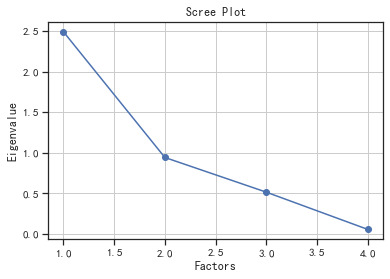

In [52]:
fa = FactorAnalyzer(4,rotation=None)
fa.fit(dfX)

ev,v = fa.get_eigenvalues()
# 可视化
# plot横轴是指标个数，纵轴是ev值
# scatter横轴是指标个数，纵轴是ev值
plt.scatter(range(1,dfX.shape[1]+1),ev)
plt.plot(range(1,dfX.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [53]:
fa = FactorAnalyzer(1, rotation="varimax")
fa.fit(dfX)
ev, v = fa.get_eigenvalues()
print("特征值",ev[0])
total, one, accumulate = fa.get_factor_variance()
print("因子载荷差异平方和",total)
print("累计因子贡献率",accumulate)

特征值 2.490043535232375
因子载荷差异平方和 [2.2947519]
累计因子贡献率 [0.57368798]


In [54]:
U = pd.DataFrame(fa.transform(dfX))
U.columns=['service']

df = pd.concat([df, U], axis=1)
df = df.drop(columns=['edu', '公共图书馆总藏量（万册）', '森林覆盖率（%）', '医疗卫生机构床位数（万张）', '普通高等学校专任教师数', '普通高中专任教师数', '中等职业学校专任教师数', '初中专任教师数', '普通小学专任教师数'])
df       

,year,province,进出口总额（万美元）,一般公共预算支出（亿元）,农村居民可支配收入（元）,地区生产总值（亿元）,城镇居民可支配收入（元）,年末城镇人口比重（百分比）,规上工业企业利润总额（亿元）,规上工业企业负债合计（亿元）,规上工业企业资产总计(亿元),lever,wave,eco,ino,service
0,2016,北京市,28234896.00,6406.77,22310,27041.2,57275,86.76,1608.26,19798.13,43093.68,1.80662,0.023418,20015.3,18.233333,0.872738
1,2017,北京市,32401742.30,6824.53,24240,29883.0,62406,86.93,2023.67,20671.02,45985.76,1.89468,0.014891,22162.9,18.658000,0.853882
2,2018,北京市,41248793.80,7471.43,26490,33106.0,67990,87.09,1530.00,21437.10,48009.50,1.91453,0.011271,24673.2,19.633333,0.836895
3,2019,北京市,41645675.20,7408.19,28928,35445.1,73849,87.35,1710.25,21974.48,52222.01,1.98853,0.021830,26297.1,21.433333,0.815088
4,2020,北京市,33647807.96,7116.18,30126,35943.3,75602,87.55,1729.55,24193.79,55167.01,2.047,0.047680,26427.2,19.733333,0.810988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,2056853.00,4637.24,11045,11159.9,30775,51.90,722.57,12951.84,20365.22,0.527039,0.018715,9852.9,14.233333,0.594833
182,2018,新疆维吾尔自治区,1999974.70,5012.45,11975,12809.4,32764,54.01,788.80,12472.70,20947.60,0.528405,0.025083,11358.6,13.800000,0.547187
183,2019,新疆维吾尔自治区,2370734.80,5315.49,13122,13597.1,34664,55.51,680.95,14000.75,23214.43,0.558587,0.007823,12058.4,16.866667,0.503197
184,2020,新疆维吾尔自治区,2137381.12,5533.16,14056,13800.7,34838,56.53,671.79,15070.20,24857.05,0.619526,0.037925,12157.8,13.300000,0.517877


## 6.对外开放度、政府规模、城乡协调发展、城镇化、工业利润总额、工业资产负债率

In [55]:
# 对外开放度
df['out'] = df['进出口总额（万美元）']/df['地区生产总值（亿元）']
df = df.drop(columns = ['进出口总额（万美元）'])

# 政府规模
df['gov'] = df['一般公共预算支出（亿元）']/df['地区生产总值（亿元）']
df = df.drop(columns = ['一般公共预算支出（亿元）'])

# 城乡协调发展
df['co'] = df['城镇居民可支配收入（元）']/df['农村居民可支配收入（元）']
df = df.drop(columns = ['城镇居民可支配收入（元）', '农村居民可支配收入（元）'])

# 城镇化
df['city'] = df['年末城镇人口比重（百分比）']

# 工业利润总额
df['income'] = df['规上工业企业利润总额（亿元）']

# 工业资产负债
df['debt'] = df['规上工业企业负债合计（亿元）']/df['规上工业企业资产总计(亿元)']

df = df.drop(columns = ['年末城镇人口比重（百分比）', '规上工业企业利润总额（亿元）', '规上工业企业负债合计（亿元）', '规上工业企业资产总计(亿元)', '地区生产总值（亿元）'])

df

,year,province,lever,wave,eco,ino,service,out,gov,co,city,income,debt
0,2016,北京市,1.80662,0.023418,20015.3,18.233333,0.872738,1044.143603,0.236926,2.567234,86.76,1608.26,0.459421
1,2017,北京市,1.89468,0.014891,22162.9,18.658000,0.853882,1084.286795,0.228375,2.574505,86.93,2023.67,0.449509
2,2018,北京市,1.91453,0.011271,24673.2,19.633333,0.836895,1245.961270,0.225682,2.566629,87.09,1530.00,0.446518
3,2019,北京市,1.98853,0.021830,26297.1,21.433333,0.815088,1174.934623,0.209005,2.552855,87.35,1710.25,0.420790
4,2020,北京市,2.047,0.047680,26427.2,19.733333,0.810988,936.135746,0.197983,2.509527,87.55,1729.55,0.438555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,0.527039,0.018715,9852.9,14.233333,0.594833,184.307476,0.415527,2.786329,51.90,722.57,0.635978
182,2018,新疆维吾尔自治区,0.528405,0.025083,11358.6,13.800000,0.547187,156.133363,0.391310,2.736033,54.01,788.80,0.595424
183,2019,新疆维吾尔自治区,0.558587,0.007823,12058.4,16.866667,0.503197,174.355914,0.390928,2.641670,55.51,680.95,0.603105
184,2020,新疆维吾尔自治区,0.619526,0.037925,12157.8,13.300000,0.517877,154.874834,0.400933,2.478515,56.53,671.79,0.606275


## 7.用熵权法衡量实体经济高质量发展

In [56]:
data1 = df[['eco', 'service', 'co', 'city', 'income', 'debt']]
#越小越优指标
data1.iloc[:,-1]=max(data1.iloc[:,-1])-data1.iloc[:,-1]  # 企业资产负债率越低越好
#某点最优型指标
a=1    #最优型数值
data1.iloc[:,2]=1-abs(data1.iloc[:,2]-a)/max(abs(data1.iloc[:,2]-a))  # 城乡居民收入差距越小越好，因此比值为1最佳
# 标准化
for i in list(data1.columns):
   # 获取各个指标的最大值和最小值
    Max = np.max(data1[i])
    Min = np.min(data1[i])
    # 标准化
    data1[i] = (data1[i] - Min)/(Max - Min)

#下面求指标比重
def bizhong(data1_bizhong):
    for column in data1_bizhong.columns:
        sigma_xij = sum(data1_bizhong[column])
        data1_bizhong[column] = data1_bizhong[column].apply(lambda x_ij: x_ij / sigma_xij if x_ij / sigma_xij != 0 else 1e-6)

    return data1_bizhong
data1_bizhong=bizhong(data1)
#下面求熵值Hi
#先算K值
k=1/ np.log(9)           #考察年度为九年
# print(k)
h_j  = (-k) * np.array([sum([pij*np.log(pij) for pij in data1_bizhong[column]]) for column in data1_bizhong.columns])
h_js = pd.Series(h_j, index=data1_bizhong.columns, name='指标的熵值')
#下面求差异系数
data1_bianyi=pd.Series(1-h_j, index=data1_bizhong.columns, name='差异系数')
#下面计算指标权重
data1_Weight = data1_bianyi / sum(data1_bianyi)
data1_Weight.name = '指标权重'
print(data1_Weight)
# 计算综合评价值
data1['economy'] = data1['eco']*data1_Weight[0]+data1['service']*data1_Weight[1]+data1['co']*data1_Weight[2]+data1['city']*data1_Weight[3]+data1['income']*data1_Weight[4]+data1['debt']*data1_Weight[5]

eco        0.156419
service    0.170586
co         0.170657
city       0.171093
income     0.159461
debt       0.171784
Name: 指标权重, dtype: float64


In [57]:
df['economy'] = data1['economy']*100
df.drop(columns=['eco', 'service', 'co', 'city', 'income', 'debt'], inplace=True)
df

,year,province,lever,wave,ino,out,gov,economy
0,2016,北京市,1.80662,0.023418,18.233333,1044.143603,0.236926,0.652610
1,2017,北京市,1.89468,0.014891,18.658000,1084.286795,0.228375,0.676250
2,2018,北京市,1.91453,0.011271,19.633333,1245.961270,0.225682,0.672300
3,2019,北京市,1.98853,0.021830,21.433333,1174.934623,0.209005,0.697268
4,2020,北京市,2.047,0.047680,19.733333,936.135746,0.197983,0.694171
...,...,...,...,...,...,...,...,...
181,2017,新疆维吾尔自治区,0.527039,0.018715,14.233333,184.307476,0.415527,0.367513
182,2018,新疆维吾尔自治区,0.528405,0.025083,13.800000,156.133363,0.391310,0.404321
183,2019,新疆维吾尔自治区,0.558587,0.007823,16.866667,174.355914,0.390928,0.411918
184,2020,新疆维吾尔自治区,0.619526,0.037925,13.300000,154.874834,0.400933,0.429968


## 8.导出数据，方便后续分析

In [30]:
df.to_csv(R"C:\Users\英俊潇洒的不爱言\Desktop\并行计算数据.csv", index=False, encoding = "utf-8-sig") # encoding = "utf-8-sig"才能不乱码

# 三、描述性统计

## 1.数据基本信息表

In [2]:
df = pd.read_csv("C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/并行计算数据.csv", encoding = "utf-8")
data = df.describe().T  # 转置一下才是标准描述性统计的表格
data.to_csv("C:/Users/英俊潇洒的不爱言/Desktop/数据描述性统计.csv", index=True, encoding = "utf-8-sig") # encoding = "utf-8-sig"才能不乱码

## 2.散点图矩阵

最后未使用

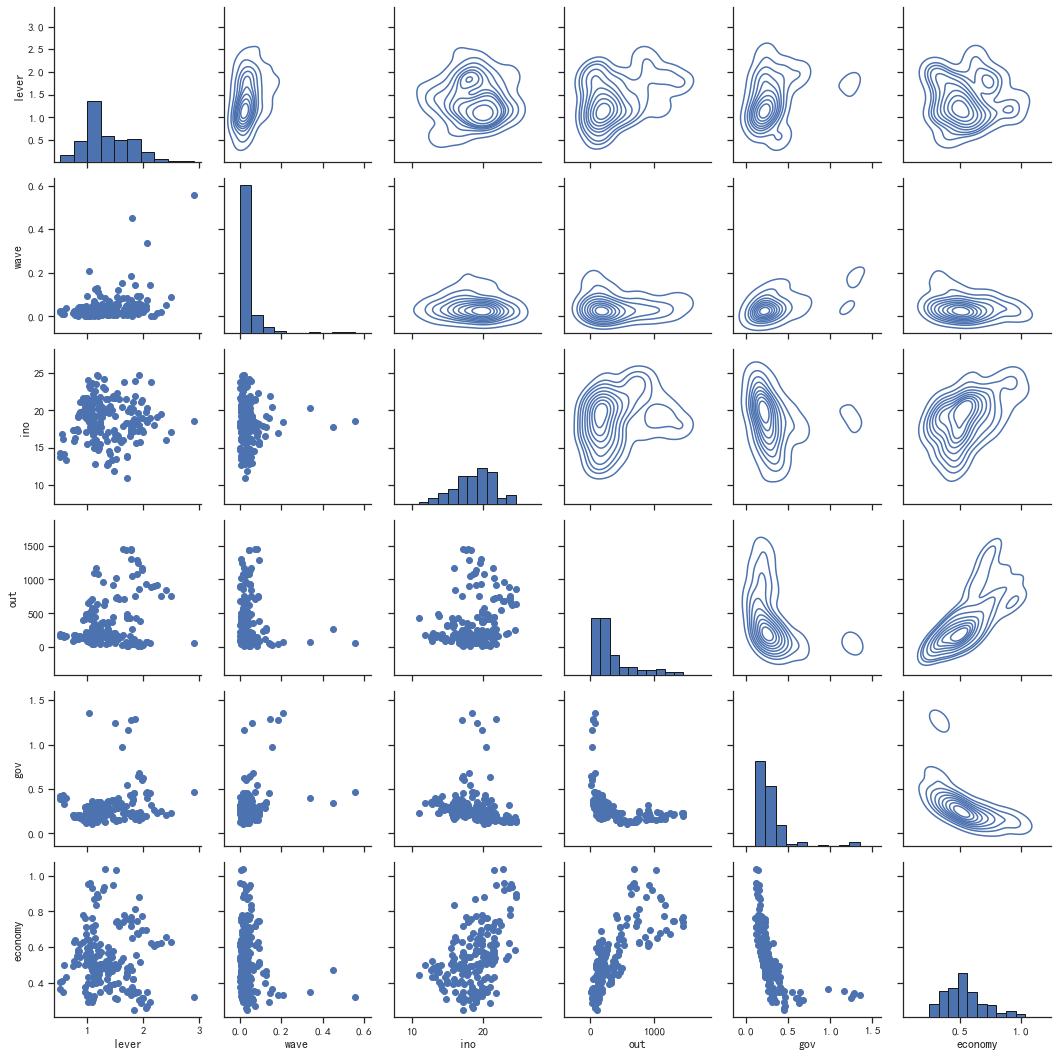

In [78]:
grid = sns.PairGrid(data=df.drop(columns=['year', 'province']))
# Map a histogram to the diagonal
grid = grid.map_lower(plt.scatter)
grid = grid.map_diag(plt.hist, bins = 10,edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_upper(sns.kdeplot)

## 3.被解释变量分布

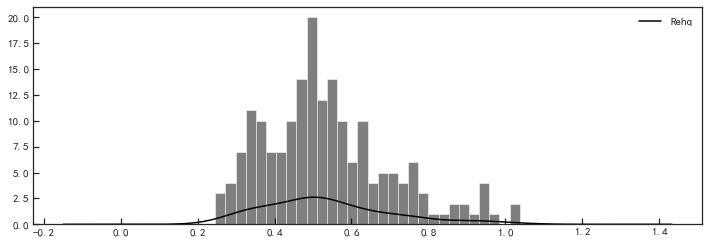

In [17]:
s = df[['economy']]
s.columns=['Rehq']
 
# 创建自定义图像
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,1,1)
# 绘制直方图
s.hist(bins=30,alpha=0.5, color='black',ax=ax)
# 绘制密度图
s.plot(kind='kde', color='black', ax=ax)

plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
plt.legend(frameon=False) # 去掉图例旁边的边框
plt.title(None)
plt.ylabel(None)

plt.savefig('C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/图/实体经济高质量发展图.png', dpi=750)

plt.show()

做KS检验看数据是否能视作正态分布，结果在5%的显著性水平下正态

In [85]:
u = df['economy'].mean()  
std = df['economy'].std()  
stats.kstest(df['economy'], 'norm', (u, std))

KstestResult(statistic=0.09215569249187106, pvalue=0.07966350432712022)

# 四、建模分析

In [3]:
import wooldridge as woo
import statsmodels.formula.api as smf
import linearmodels as plm

In [4]:
df = pd.read_csv("C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/并行计算数据.csv", encoding = "utf-8")
df = df.set_index(['province', 'year'], drop=True) # 设置面板数据
df

lever      wave        ino          out       gov   economy
province year                                                                
北京市      2016  1.806620  0.023418  18.233333  1044.143603  0.236926  0.652610
         2017  1.894685  0.014891  18.658000  1084.286795  0.228375  0.676250
         2018  1.914532  0.011271  19.633333  1245.961270  0.225682  0.672300
         2019  1.988531  0.021830  21.433333  1174.934623  0.209005  0.697268
         2020  2.047000  0.047680  19.733333   936.135746  0.197983  0.694171
...                 ...       ...        ...          ...       ...       ...
新疆维吾尔自治区 2017  0.527039  0.018715  14.233333   184.307476  0.415527  0.367513
         2018  0.528405  0.025083  13.800000   156.133363  0.391310  0.404321
         2019  0.558587  0.007823  16.866667   174.355914  0.390928  0.411918
         2020  0.619526  0.037925  13.300000   154.874834  0.400933  0.429968
         2021  0.583022  0.011870  14.100000   148.963504  0.329637  0.501278

[186 rows x 6 columns]

## 1.固定效应模型

### hausman检验看用固定效应还是随机效应

In [33]:
reg_fe = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df)
results_fe = reg_fe.fit()

reg_re = plm.RandomEffects.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',
    data = df)
results_re = reg_re.fit()

b_fe = results_fe.params
b_re = results_re.params
b_diff = b_fe - b_re
v_fe = results_fe.cov
v_re = results_re.cov
v_diff = v_fe - v_re
f = len(b_fe)  # 自由度

table = pd.DataFrame({'FE':b_fe,'RE':b_re,'Difference':b_diff,'sqrt(diag(v_fe-v_re))':np.sqrt(np.diag(v_diff))})
chi2 = np.dot(b_diff.T,  np.linalg.inv(v_diff).dot(b_diff))
pval = 1 - stats.chi2.cdf(chi2, f)

print(table)
print()
print(f'chi-Squared: {chi2:.2f}')
print(f'degrees of freedom: {f}')
print(f'p-Value:{pval:.5f}')

             FE        RE  Difference  sqrt(diag(v_fe-v_re))
gov   -0.492132 -0.107806   -0.384326               0.038243
lever  0.073082  0.178186   -0.105103               0.006745
out    0.000137  0.000351   -0.000214               0.000027
wave   0.008618 -0.089707    0.098325                    NaN

chi-Squared: 82.62
degrees of freedom: 4
p-Value:0.00000


在1%的显著性水平下拒绝原假设，应使用固定效应模型

因为面板数据较短，采用Fixed Effect，FE结果如下：

In [6]:
reg_fe = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df)
results_fe = reg_fe.fit()
results_fe

Dep. Variable:,economy,R-squared:,0.2545
Estimator:,PanelOLS,R-squared (Between):,0.0549
No. Observations:,186,R-squared (Within):,0.2545
Date:,"Wed, Jan 10 2024",R-squared (Overall):,0.0558
Time:,11:29:50,Log-likelihood,372.69
Cov. Estimator:,Unadjusted,,
,,F-statistic:,12.887
Entities:,31,P-value,0.0000
Avg Obs:,6.0000,Distribution:,"F(4,151)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,12.887


In [1]:
import numpy as np
3.1682*np.sqrt((6*31-4)/((6-1)*31-4))

3.4782421206029386

In [3]:
3.01*np.sqrt((6*31-4)/((6-1)*31-4-1))

3.3155574694662335

### 缓解内生性问题，用滞后一期的被解释变量进去回归

In [67]:
df['late'] = np.nan # 初始全为空
Late = pd.DataFrame([])
for i in range(int(len(df)/6)): 
    tmp = df.iloc[6*i:6*(i+1), :]
    for i in range(5):
        tmp.iloc[i+1,-1] = tmp.iloc[i,-2] # 滞后一期的值
    Late = Late.append(tmp) # 这里不能忽略索引，不然不是面板数据了
Late = Late.dropna() # 删除第一期
Late

lever      wave        ino          out       gov   economy  \
province year                                                                   
北京市      2017  1.894685  0.014891  18.658000  1084.286795  0.228375  0.676250   
         2018  1.914532  0.011271  19.633333  1245.961270  0.225682  0.672300   
         2019  1.988531  0.021830  21.433333  1174.934623  0.209005  0.697268   
         2020  2.047000  0.047680  19.733333   936.135746  0.197983  0.694171   
         2021  1.974272  0.049712  19.000000  1147.479876  0.175539  0.775359   
...                 ...       ...        ...          ...       ...       ...   
新疆维吾尔自治区 2017  0.527039  0.018715  14.233333   184.307476  0.415527  0.367513   
         2018  0.528405  0.025083  13.800000   156.133363  0.391310  0.404321   
         2019  0.558587  0.007823  16.866667   174.355914  0.390928  0.411918   
         2020  0.619526  0.037925  13.300000   154.874834  0.400933  0.429968   
         2021  0.583022  0.011870  14.100000   148.963504  0.329637  0.501278   

                   late  
province year            
北京市      2017  0.652610  
         2018  0.676250  
         2019  0.672300  
         2020  0.697268  
         2021  0.694171  
...                 ...  
新疆维吾尔自治区 2017  0.346932  
         2018  0.367513  
         2019  0.404321  
         2020  0.411918  
         2021  0.429968  

[155 rows x 7 columns]

In [68]:
reg_fe = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + late + EntityEffects',  # Entityeffects表示特定因素
    data = Late)
results_fe = reg_fe.fit()
results_fe

Dep. Variable:,economy,R-squared:,0.6130
Estimator:,PanelOLS,R-squared (Between):,0.9569
No. Observations:,155,R-squared (Within):,0.6130
Date:,"Mon, Jan 08 2024",R-squared (Overall):,0.9557
Time:,01:19:59,Log-likelihood,375.91
Cov. Estimator:,Unadjusted,,
,,F-statistic:,37.693
Entities:,31,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(5,119)"
Min Obs:,5.0000,,
Max Obs:,5.0000,F-statistic (robust):,37.693


核心解释变量系数、显著性变化不大，认为外生

## 2.中介效应

sobel检验中介效应，Y关于X回归（已经做过了），M关于X回归，Y关于X和M回归，如果第一个显著，第二个显著，第三个显著且X的显著性比第一个里的低那就说明有中介效应

In [5]:
# M做被解释变量X做解释变量的回归

reg_fe1 = plm.PanelOLS.from_formula(
    formula='ino ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df)
results_fe1 = reg_fe1.fit()
results_fe1

Dep. Variable:,ino,R-squared:,0.1485
Estimator:,PanelOLS,R-squared (Between):,0.4847
No. Observations:,186,R-squared (Within):,0.1485
Date:,"Mon, Jan 08 2024",R-squared (Overall):,0.4828
Time:,20:06:19,Log-likelihood,-313.87
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6.5811
Entities:,31,P-value,0.0001
Avg Obs:,6.0000,Distribution:,"F(4,151)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,6.5811


In [6]:
# Y做被解释变量X, M做解释变量的回归

reg_fe2 = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + ino + EntityEffects',  # Entityeffects表示特定因素
    data = df)
results_fe2 = reg_fe2.fit()
results_fe2

Dep. Variable:,economy,R-squared:,0.3155
Estimator:,PanelOLS,R-squared (Between):,0.3527
No. Observations:,186,R-squared (Within):,0.3155
Date:,"Mon, Jan 08 2024",R-squared (Overall):,0.3526
Time:,20:06:21,Log-likelihood,380.63
Cov. Estimator:,Unadjusted,,
,,F-statistic:,13.828
Entities:,31,P-value,0.0000
Avg Obs:,6.0000,Distribution:,"F(5,150)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,13.828


计算Z统计量判断中介效应显著性并计算占比

In [15]:
from scipy.stats import norm

a = results_fe1.params.loc['lever']
b = results_fe2.params.loc['ino']
sea = results_fe1.cov.loc['lever', 'lever']
seb = results_fe2.cov.loc['ino', 'ino']
z = a*b/np.sqrt(a**2*seb**2+b**2*sea**2)

p_value = 2*(1 - norm.cdf(abs(z)))  # 双边检验
print("P-Value: %.4f"%p_value)

if p_value<0.01:
    propotion = (results_fe.params.loc['lever']-results_fe2.params.loc['lever']) / results_fe.params.loc['lever'] # 间接效应/直接效应
    print(f"中介效应在总效应中的占比: {propotion}")
else:
    print("中介效应不显著")

P-Value: 0.0000
中介效应在总效应中的占比: 0.4347713924149255


## 3.地理异质性分析

In [22]:
east = ['北京市', '天津市', '河北省', '上海市', '江苏省', '浙江省', '福建省', '辽宁省', '山东省', '广东省', '海南省']
mid = ['河南省', '湖北省', '湖南省', '重庆市', '吉林省', '黑龙江省', '安徽省', '山西省', '江西省']
west = ['内蒙古自治区', '广西壮族自治区', '四川省', '贵州省', '云南省', '西藏自治区', '陕西省', '甘肃省', '青海省', '宁夏回族自治区', '新疆维吾尔自治区']

df_e=df.loc[east, :]
df_m=df.loc[mid, :]
df_w=df.loc[west, :]

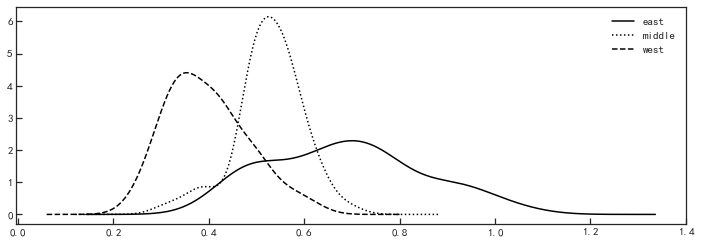

In [24]:
# 创建自定义图像
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,1,1)

df_e[['economy']].rename(columns={'economy': 'east'}).plot(kind='kde', color='black', linestyle='-',ax=ax)
df_m[['economy']].rename(columns={'economy': 'middle'}).plot(kind='kde', color='black', linestyle=':',ax=ax)
df_w[['economy']].rename(columns={'economy': 'west'}).plot(kind='kde', color='black', linestyle='--',ax=ax)

plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
plt.legend(frameon=False) # 去掉图例旁边的边框
plt.title(None)
plt.ylabel(None)

plt.savefig('C:/Users/英俊潇洒的不爱言/Desktop/并行计算论文/图/分地区实体经济高质量发展图.png', dpi=750)

plt.show()

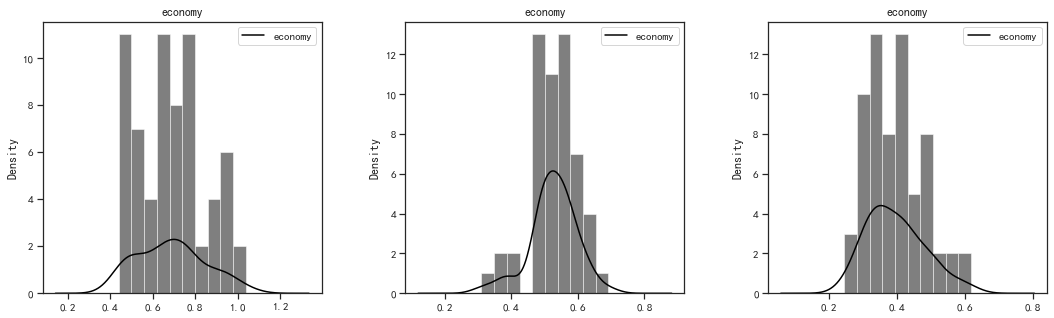

In [10]:
# 创建自定义图像
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

# 绘制直方图
df_e[['economy']].hist(bins=10,alpha=0.5, color='black',ax=ax1)
df_e[['economy']].plot(kind='kde', color='black', ax=ax1)
# 绘制直方图
df_m[['economy']].hist(bins=10,alpha=0.5, color='black',ax=ax2)
df_m[['economy']].plot(kind='kde', color='black', ax=ax2)
# 绘制直方图
df_w[['economy']].hist(bins=10,alpha=0.5, color='black',ax=ax3)
df_w[['economy']].plot(kind='kde', color='black', ax=ax3)


# 显示自定义图像
plt.show()

In [15]:
reg_fe_e = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df_e)
results_fe_e = reg_fe_e.fit()
print("东部地区结果\n\n",results_fe_e)

reg_fe_m = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df_m)
results_fe_m = reg_fe_m.fit()
print("中部地区结果\n\n",results_fe_m)

reg_fe_w = plm.PanelOLS.from_formula(
    formula='economy ~lever + wave + out + gov + EntityEffects',  # Entityeffects表示特定因素
    data = df_w)
results_fe_w = reg_fe_w.fit()
print("西部地区结果\n\n",results_fe_w)

东部地区结果

                           PanelOLS Estimation Summary                           
Dep. Variable:                economy   R-squared:                        0.3197
Estimator:                   PanelOLS   R-squared (Between):              0.3591
No. Observations:                  66   R-squared (Within):               0.3197
Date:                Tue, Jan 09 2024   R-squared (Overall):              0.3589
Time:                        10:41:53   Log-likelihood                    129.09
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.9919
Entities:                          27   P-value                           0.0005
Avg Obs:                       2.4444   Distribution:                    F(4,51)
Min Obs:                       0.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             5.9919
                   